# <a title="Human Activity Recognition" href="https://github.com/MichaelFan36/STAT430/blob/main/LSTM_Final_Project.ipynb" > LSTMs for Human Activity Recognition</a>

Human Activity Recognition (HAR) using smartphones dataset and an LSTM RNN. Classifying the type of movement amongst six categories:
- WALKING,
- WALKING_UPSTAIRS,
- WALKING_DOWNSTAIRS,
- SITTING,
- STANDING,
- LAYING.

In this project, we are going to modify the existing code of LSTMs of recognizing human activities.

<p align="center">
  <a href="
" target="_blank"><img src="" 
</p>

## Package Import

Importing key packages and avoid possible warnings

In [1]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

<IPython.core.display.Javascript object>

In [2]:
# All Includes
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.disable_v2_behavior() 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics

## Tensorflow Version Check

In [3]:
print(tf.__version__)

2.3.1


## Input Dataset

Show input signal types and all the labels we are going to predict

Using the exisiting dataset downloaded from UCI HAR Dataset

In [3]:
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

In [4]:
DATASET_PATH = "data/" + "UCI HAR Dataset/"

In [5]:
TRAIN = "train/"
TEST = "test/"

def load_signals(signals_paths):
    signals = []
    
    for signal_type_path in signals_paths:
        file = open(signal_type_path, 'r')
        signals.append(
            [np.array(serie, dtype=np.float32) for serie in 
             [row.replace('  ', ' ').strip().split(' ') for row in file]
            ]
        )
        file.close()
    
    return np.transpose(np.array(signals), (1, 2, 0))

train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_signals(train_signals_paths)
X_test = load_signals(test_signals_paths)

def load_y(y_path):
    file = open(y_path, 'r')
    y_loaded = np.array(
        [elem for elem in 
         [row.replace('  ', ' ').strip().split(' ') for row in file]
        ], 
        dtype=np.int32
    )
    file.close()
    
    return y_loaded - 1

y_train = load_y(DATASET_PATH + TRAIN + "y_train.txt")
y_test = load_y(DATASET_PATH + TEST + "y_test.txt")

In [6]:
print(X_train.shape)
print(y_train.shape)

(7352, 128, 9)
(7352, 1)


## Dataset Preprocess

Normalizing and Augmenting Dataset

In [7]:
def preprocess(x_train):
  for x in range(x_train.shape[0]):
    x_train[x] = ((x_train[x].astype(float) - np.mean(x_train[x]).astype(float)) / np.maximum(np.std(x_train[x].astype(float)), 0.001))

In [8]:
# .. code here ...
from random import choice
sequence = [i for i in range(X_train.shape[0])]
result = np.zeros(150)
# print(x_train[0])
for i in range(150):
  result[i] = int(choice(sequence))
# print(result[0])
x_train_flipped = [[[0] * 9] * 128] * 150
y_train_flipped = [[0] * 1] * 150
for i in range(150):
  x_train_flipped[i] = np.fliplr(X_train[int(result[i])])
  y_train_flipped[i] = y_train[int(result[i])]
# preprocess(x_train)
x_train_aug = np.concatenate((X_train,x_train_flipped))
y_train_aug = np.concatenate((y_train,y_train_flipped))

In [9]:
preprocess(x_train_aug)
preprocess(X_test)

## Basic Parameters Setup(Single Model)

In [10]:
# Input Data 

training_data_count = len(x_train_aug)
test_data_count = len(X_test)
n_steps = len(x_train_aug[0])
n_input = len(x_train_aug[0][0])

n_hidden = 32 
n_classes = 6 

learning_rate = 0.0028
lambda_loss_amount = 0.0017
training_iters = training_data_count * 150
batch_size = 1500
display_iter = 60000

## LSTM Model Structure

In each cells, we are going to input two simple cells to construct

In [11]:
def LSTM_RNN(_X, _weights, _biases):
    _X = tf.transpose(_X, [1, 0, 2])
    _X = tf.reshape(_X, [-1, n_input]) 
    
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    _X = tf.split(_X, n_steps, 0) 

    lstm_cell_1 = tf.keras.layers.LSTMCell(n_hidden, unit_forget_bias=1.0)
    lstm_cell_2 = tf.keras.layers.LSTMCell(n_hidden, unit_forget_bias=1.0)
    lstm_cells = tf.keras.layers.StackedRNNCells([lstm_cell_1, lstm_cell_2])
    outputs, states = tf.nn.static_rnn(lstm_cells, _X, dtype=tf.float32)
    lstm_last_output = outputs[-1]
    
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_, n_classes=n_classes):
    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]

In [13]:
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])),
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


## Training and Testing(Single Model)

In [14]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

In [15]:
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

step = 1

while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(x_train_aug, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train_aug, step, batch_size))

    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

Training iter #1500:   Batch Loss = 3.795198, Accuracy = 0.10266666859388351
PERFORMANCE ON TEST SET: Batch Loss = 2.733365058898926, Accuracy = 0.1435357928276062
Training iter #60000:   Batch Loss = 1.175253, Accuracy = 0.8159999847412109
PERFORMANCE ON TEST SET: Batch Loss = 1.3151429891586304, Accuracy = 0.7933491468429565
Training iter #120000:   Batch Loss = 0.945955, Accuracy = 0.9160000085830688
PERFORMANCE ON TEST SET: Batch Loss = 1.1335797309875488, Accuracy = 0.857821524143219
Training iter #180000:   Batch Loss = 0.869435, Accuracy = 0.9300000071525574
PERFORMANCE ON TEST SET: Batch Loss = 1.0756818056106567, Accuracy = 0.879199206829071
Training iter #240000:   Batch Loss = 0.802375, Accuracy = 0.9359999895095825
PERFORMANCE ON TEST SET: Batch Loss = 1.0423096418380737, Accuracy = 0.8873430490493774
Training

## Print Training and Testing Accuracies (Single Model)

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


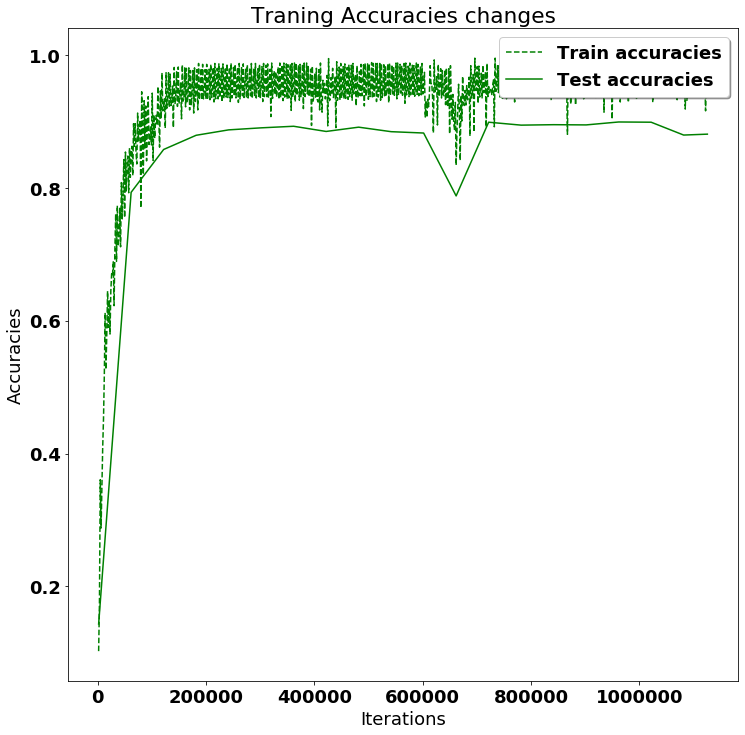

In [16]:
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Traning Accuracies changes")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Accuracies')
plt.xlabel('Iterations')

plt.show()

## Print Training and Testing Losses (Single Model)

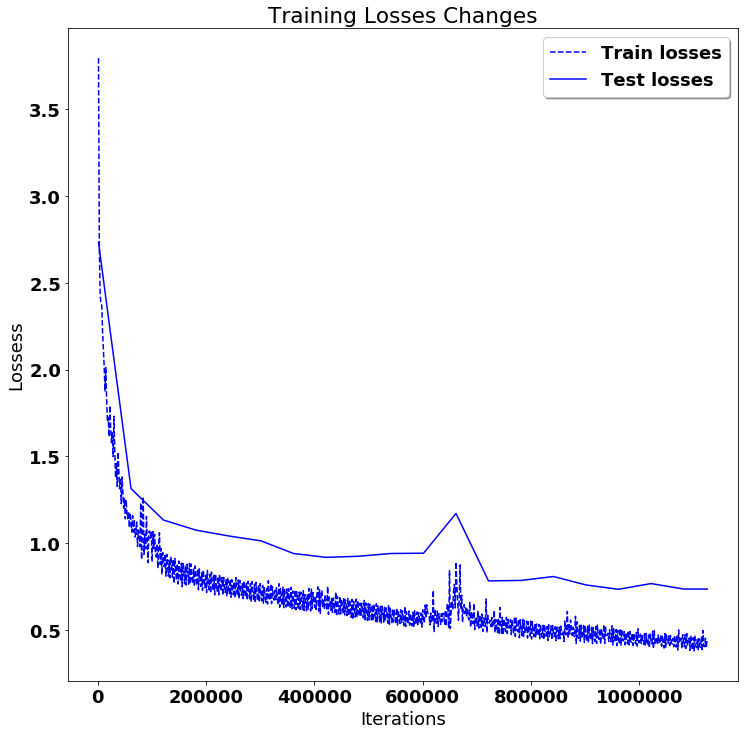

In [17]:
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")

plt.title("Training Losses Changes")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Lossess')
plt.xlabel('Iterations')

plt.show()

## Print Confusion matrix for all data (Single Model)

Testing Accuracy: 88.08958530426025%

Precision: 88.34625174559581%
Recall: 88.08958262639973%
f1_score: 88.0222435304146%

Confusion Matrix:
[[463   2  31   0   0   0]
 [ 22 418  31   0   0   0]
 [ 13  22 384   0   1   0]
 [  0  26   0 348 117   0]
 [  0   2   0  57 473   0]
 [  0  27   0   0   0 510]]

Confusion matrix (normalized to % of total test data):
[[0.9078431  0.00392157 0.06078431 0.         0.         0.        ]
 [0.04313726 0.81960785 0.06078431 0.         0.         0.        ]
 [0.0254902  0.04313726 0.7529412  0.         0.00196078 0.        ]
 [0.         0.05098039 0.         0.6823529  0.22941177 0.        ]
 [0.         0.00392157 0.         0.11176471 0.92745095 0.        ]
 [0.         0.05294118 0.         0.         0.         1.        ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


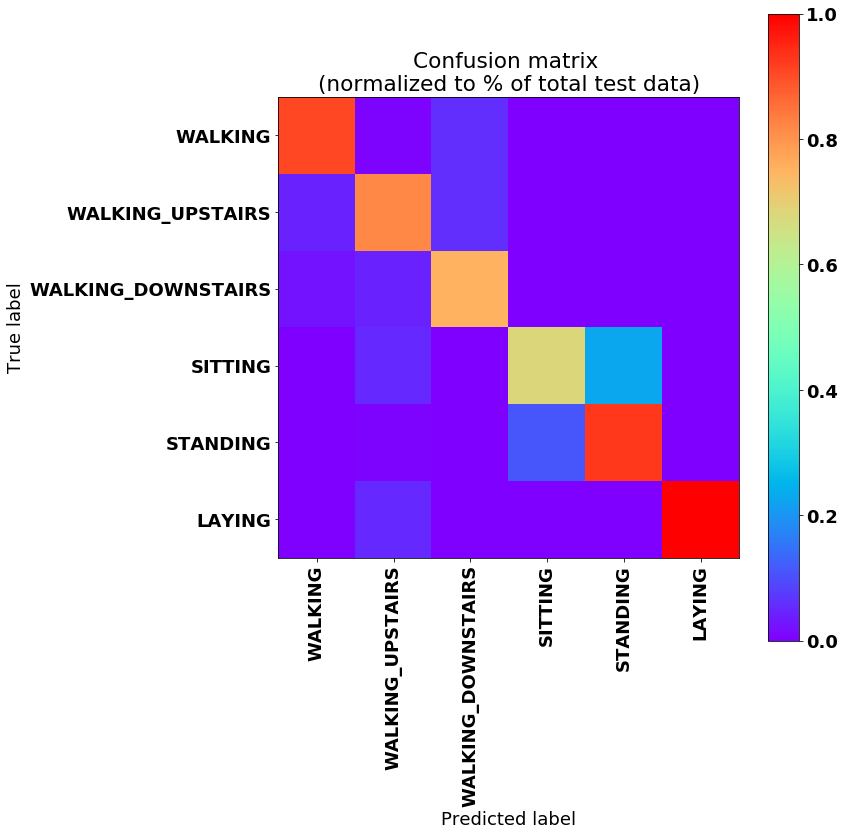

In [18]:
predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalized_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100
normalized_confusion_matrix = normalized_confusion_matrix / np.amax(normalized_confusion_matrix)
print("")
print("Confusion matrix (normalized to % of total test data):")
print(normalized_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalized_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalized to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Ensemble Model Structure (2 Models in the ensemble model)

In [12]:
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])),
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred1 = LSTM_RNN(x, weights, biases)
pred2 = LSTM_RNN(x, weights, biases)

pred = (pred1 + pred2) / 2
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


## Training and Testing(Ensemble Model)

In [13]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

In [14]:
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

step = 1

while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(x_train_aug, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train_aug, step, batch_size))

    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

Training iter #1500:   Batch Loss = 3.573352, Accuracy = 0.18533332645893097
PERFORMANCE ON TEST SET: Batch Loss = 2.9342899322509766, Accuracy = 0.2965727746486664
Training iter #60000:   Batch Loss = 1.362806, Accuracy = 0.8473333120346069
PERFORMANCE ON TEST SET: Batch Loss = 1.5059170722961426, Accuracy = 0.80861896276474
Training iter #120000:   Batch Loss = 1.123151, Accuracy = 0.9046666622161865
PERFORMANCE ON TEST SET: Batch Loss = 1.2889775037765503, Accuracy = 0.8568035364151001
Training iter #180000:   Batch Loss = 1.001828, Accuracy = 0.9200000166893005
PERFORMANCE ON TEST SET: Batch Loss = 1.2078880071640015, Accuracy = 0.8859857320785522
Training iter #240000:   Batch Loss = 0.897385, Accuracy = 0.9333333373069763
PERFORMANCE ON TEST SET: Batch Loss = 1.1928675174713135, Accuracy = 0.8893790245056152
Trainin

## Print Training and Testing Accuracies (Ensemble Model)

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


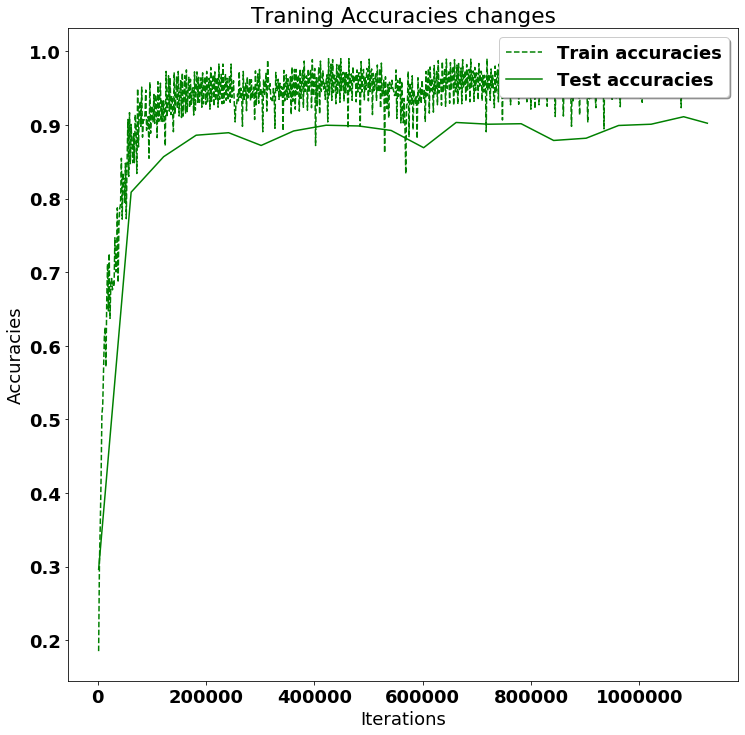

In [15]:
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Traning Accuracies changes")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Accuracies')
plt.xlabel('Iterations')

plt.show()

## Print Training and Testing Losses (Ensemble Model)

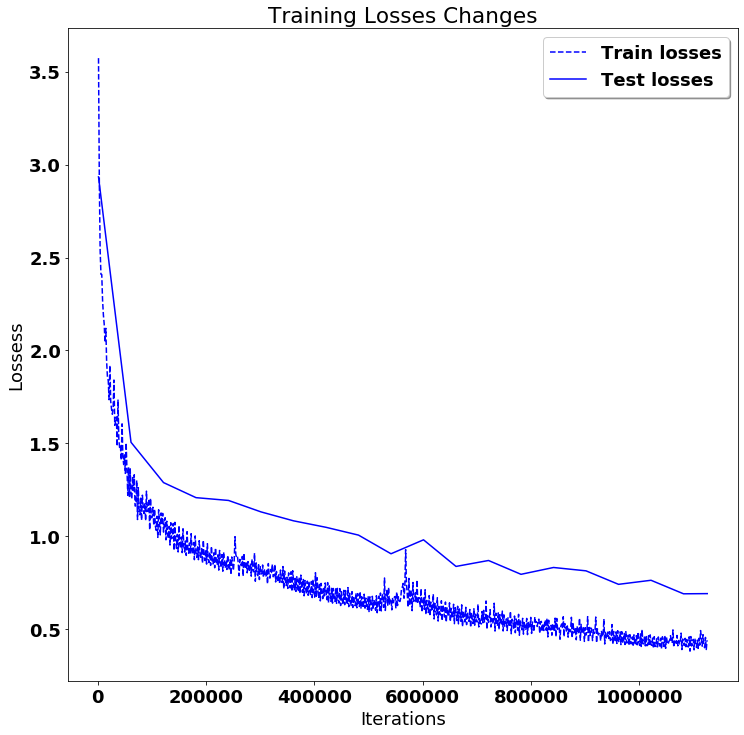

In [16]:
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")

plt.title("Training Losses Changes")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Lossess')
plt.xlabel('Iterations')

plt.show()

## Print Confusion matrix for all data (Ensemble Model)

Testing Accuracy: 90.22734761238098%

Precision: 90.5575126016363%
Recall: 90.22734984730234%
f1_score: 90.23856787852095%

Confusion Matrix:
[[448   1  47   0   0   0]
 [ 11 419  39   1   1   0]
 [ 11   1 408   0   0   0]
 [  1  22   0 392  76   0]
 [  1   0   0  49 482   0]
 [  0  27   0   0   0 510]]

Confusion matrix (normalized to % of total test data):
[[0.8784314  0.00196078 0.09215686 0.         0.         0.        ]
 [0.02156863 0.8215686  0.07647058 0.00196078 0.00196078 0.        ]
 [0.02156863 0.00196078 0.8        0.         0.         0.        ]
 [0.00196078 0.04313726 0.         0.76862746 0.14901961 0.        ]
 [0.00196078 0.         0.         0.09607843 0.94509804 0.        ]
 [0.         0.05294118 0.         0.         0.         1.        ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


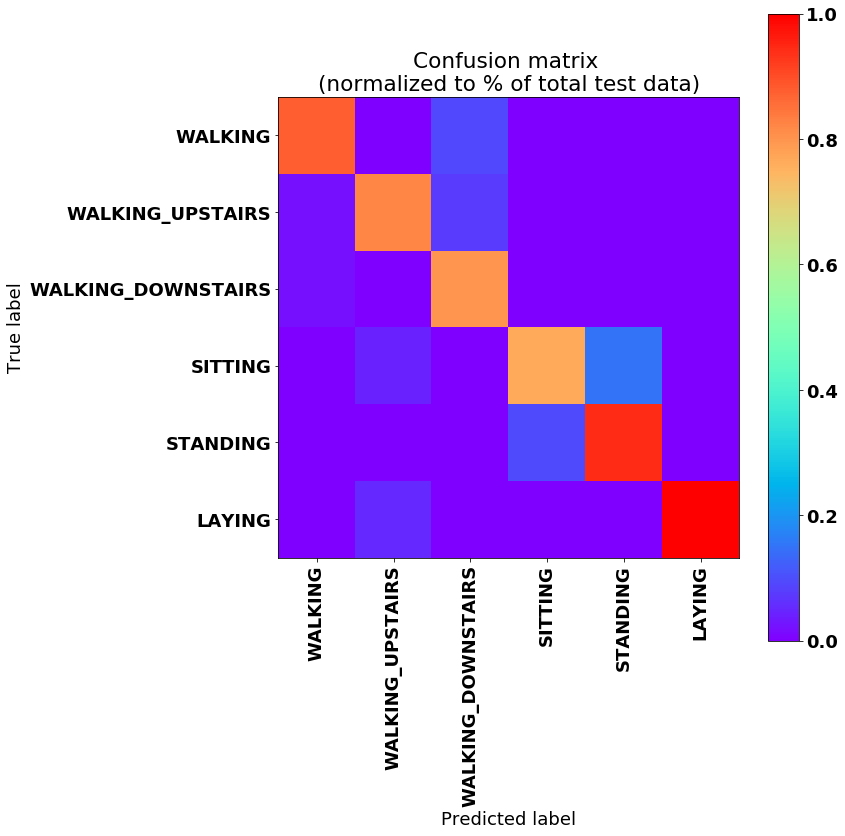

In [17]:
predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalized_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100
normalized_confusion_matrix = normalized_confusion_matrix / np.amax(normalized_confusion_matrix)
print("")
print("Confusion matrix (normalized to % of total test data):")
print(normalized_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalized_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalized to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()